In [1]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools import DuckDuckGoSearchRun

In [2]:
import os
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

In [3]:
chat_model = ChatOpenAI(model="gpt-4", openai_api_key=openai_api_key)
chat_model.invoke("Hey there").content

'Hello! How can I assist you today?'

In [4]:
search_tool = DuckDuckGoSearchRun()
search_tool.invoke("What is the gdp of Kenya?")

DuckDuckGoSearchException: https://lite.duckduckgo.com/lite/ 202 Ratelimit

In [5]:
from langchain_tavily import TavilySearch
search_tool = TavilySearch(api_key="your_tavily_key")
search_tool.invoke("What is the GDP of Kenya?")

{'query': 'What is the GDP of Kenya?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://tradingeconomics.com/kenya/gdp',
   'title': 'Kenya GDP - Trading Economics',
   'content': 'Login Calendar News Markets Commodities Indexes Shares Currencies Crypto Bonds Earnings Holidays Countries United States United Kingdom Euro Area Australia Canada Japan China Brazil Russia India More Countries Indicators Interest Rate Inflation Rate Unemployment Rate GDP Growth GDP per Capita Current Account Gold Reserves Government Debt Crude Oil Production Gasoline Prices Credit Rating More Indicators Forecasts Markets & Indicators Countries Countries Indicators Commodities Indexes Currencies Crypto Bonds Solutions Data Subscriptions API Access Pricing Apps App Store Google Play Twitter About Customers Investors Careers About us Contact Kenya GDP Summary Stats Forecast Download Download Data Excel Add-in API Access The Gross Domestic Product (GDP) in Kenya was wor

In [6]:
repl = PythonREPL()
code = """
x = 5
y = x * 2
print(y)
"""

In [7]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [8]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
/tmp/ipykernel_30227/290981387.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
/tmp/ipykernel_30227/290981387.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [9]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [10]:
make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    )

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [11]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [12]:
research_agent = create_react_agent(
    chat_model,
    tools=[search_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

In [13]:
chart_agent = create_react_agent(
    chat_model,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

In [14]:
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]: 
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    return Command(update={"messages": result["messages"]},goto=goto)

In [15]:
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]: 
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    return Command(update={"messages": result["messages"]},goto=goto)

In [16]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

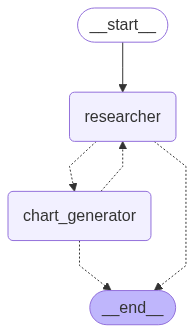

In [17]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})